In [1]:
import sklearn
print(sklearn.__version__)

1.3.0


In [2]:
import numpy as np
print(np.__version__)

1.24.3


In [3]:
import scipy
print(scipy.__version__)

1.10.1


In [4]:
import sys
print(sys.version)

3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]


In [5]:
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [6]:
with open('data_v2.pkl', 'rb') as f:
    data_reload = pickle.load(f)

X_train = data_reload['X_train']
X_test  = data_reload['X_test']
X_val   = data_reload['X_val']
y_train = data_reload['y_train']
y_test  = data_reload['y_test']
y_val   = data_reload['y_val']

In [7]:
with open('data_processed_pca.pkl', 'rb') as f:
    data_reload_pca = pickle.load(f)

X_train_pca = data_reload_pca['X_train']
X_test_pca  = data_reload_pca['X_test']
X_val_pca   = data_reload_pca['X_val']
y_train_pca = data_reload_pca['y_train']
y_test_pca  = data_reload_pca['y_test']
y_val_pca   = data_reload_pca['y_val']

In [8]:
X_val_pca

array([[-0.16498682,  0.14551382, -0.06463948, ...,  0.00393442,
        -0.05291277,  0.01530733],
       [-0.07176278, -0.04087625, -0.05672421, ..., -0.02758872,
        -0.00248838, -0.01617708],
       [-0.04086514, -0.0295404 , -0.19455766, ...,  0.09348502,
         0.03349855,  0.05233312],
       ...,
       [ 0.45157734,  0.02544207,  0.05915518, ..., -0.02311164,
        -0.01795097, -0.00532036],
       [-0.17575657, -0.26961752,  0.24123692, ...,  0.00073175,
         0.02302733,  0.0031939 ],
       [-0.08111259, -0.04405105, -0.07143738, ..., -0.00250087,
         0.01774288,  0.03144966]])

In [9]:
# Define the baseline model(most_frequent class classifier)
baseline_model = DummyClassifier(strategy='most_frequent')


# try predict
def cv_baseline(X_train, y_train):
    cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=10, scoring='accuracy')
    print("Cross-Validation Scores:", cv_scores)
    print("Mean CV Accuracy:", cv_scores.mean())

def training_baseline(X_train, y_train):
    baseline_model.fit(X_train, y_train)

def validation_baseline(X_val, y_val):
    y_val_pred = baseline_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print("Validation Accuracy:", val_accuracy)

def prediction_baseline(X_test, y_test):
    y_pred = baseline_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)

cv_baseline(X_train, y_train)
training_baseline(X_train, y_train)

validation_baseline(X_val, y_val)

prediction_baseline(X_test, y_test)

import numpy as np
print("Training Label distribution:", np.bincount(y_train)/ len(y_train))
print("Validation Label distribution:", np.bincount(y_val)/ len(y_val))
print("Testing Label distribution:", np.bincount(y_test)/ len(y_test))


# Another model
param_dist_svc = {
    'C': randint(1, 100),            # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'],      # Kernel coefficient
    'degree': randint(1, 10),        # Degree of the polynomial kernel
}
# # try predict
# def cv_svc(X_train, y_train):
#     cv_scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')
#     print("Cross-Validation Scores:", cv_scores)
#     print("Mean CV Accuracy:", cv_scores.mean())

# def training_svc(X_train, y_train):
#     svc.fit(X_train, y_train)

# def validation_svc(X_val, y_val):
#     y_val_pred = svc.predict(X_val)
#     val_accuracy = accuracy_score(y_val, y_val_pred)
#     print("Validation Accuracy:", val_accuracy)

# def prediction_svc(X_test, y_test):
#     y_pred = svc.predict(X_test)
#     test_accuracy = accuracy_score(y_test, y_pred)
#     print("Test Accuracy:", test_accuracy)

def workflow(model, param_dist, X_train, y_train, X_val, y_val, X_test, y_test):
    start_time = time.time()
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_jobs=10, n_iter=10, cv=5)
    random_search.fit(X_val, y_val)
    print("--- %s seconds ---" % (time.time() - start_time))
    # Get the best hyperparameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    # Train the model
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train)
    # Predict
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)

print("==================================")
print("SVC: tokenized dataset:")
workflow(SVC(), param_dist_svc, X_train, y_train, X_val, y_val, X_test, y_test)
print("==================================")
print("SVC: PCA processed dataset:")
workflow(SVC(), param_dist_svc, X_train_pca, y_train_pca, X_val_pca, y_val_pca, X_test_pca, y_test_pca)

# Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 11)
}
# def training_rf(X_train, y_train):
#     rf_classifier.fit(X_train, y_train)

# def validation_rf(X_val, y_val):
#     y_val_pred = rf_classifier.predict(X_val)
#     val_accuracy = accuracy_score(y_val, y_val_pred)
#     print("Validation Accuracy:", val_accuracy)

# def prediction_rf(X_test, y_test):
#     y_pred = rf_classifier.predict(X_test)
#     test_accuracy = accuracy_score(y_test, y_pred)
#     print("Test Accuracy:", test_accuracy)

print("==================================")
print("Random Forest: tokenized dataset:")
workflow(RandomForestClassifier(n_estimators=100, random_state=42), param_dist_rf, X_train, y_train, X_val, y_val, X_test, y_test)
print("==================================")
print("Random Forest: PCA processed dataset:")
workflow(RandomForestClassifier(n_estimators=100, random_state=42), param_dist_rf, X_train_pca, y_train_pca, X_val_pca, y_val_pca, X_test_pca, y_test_pca)

# Overfitting analysis

Cross-Validation Scores: [0.73344103 0.73344103 0.73344103 0.73344103 0.73344103 0.73462783
 0.73462783 0.73462783 0.73462783 0.73462783]
Mean CV Accuracy: 0.7340344328204484
Validation Accuracy: 0.7051282051282052
Test Accuracy: 0.7368024132730016
Training Label distribution: [0.73403395 0.26596605]
Validation Label distribution: [0.70512821 0.29487179]
Testing Label distribution: [0.73680241 0.26319759]
SVC: tokenized dataset:
--- 32.18793487548828 seconds ---
Best Hyperparameters: {'C': 79, 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy: 0.9969834087481146
SVC: PCA processed dataset:
--- 0.43184518814086914 seconds ---
Best Hyperparameters: {'C': 28, 'degree': 9, 'gamma': 'auto', 'kernel': 'linear'}
Test Accuracy: 0.9683257918552036
Random Forest: tokenized dataset:
--- 50.746312379837036 seconds ---
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 143}
Test Accuracy: 0.9917043740573153
Random Forest: PCA processed dataset:
--- 16.6

# Naive Bayes

## For Data_v2

In [10]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Define hyperparameter grid for grid search
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Perform grid search using training and validation sets
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_val, y_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'alpha': 0.001}


In [25]:
# Initialize Naive Bayes classifier with best hyperparameters
nb_best = MultinomialNB(**grid_search.best_params_)

# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(nb_best, X_val, y_val, cv=10, scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean CV Accuracy (after hyperparameter tuning):", cv_scores.mean())

Mean CV Accuracy (after hyperparameter tuning): 0.9894395078605605


In [26]:
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(nb_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean Stratified CV Accuracy (after hyperparameter tuning):", scv_scores.mean())

Mean Stratified CV Accuracy (after hyperparameter tuning): 0.9894395078605605


In [27]:
# Finally, train the model on the entire training set and evaluate it on the test set
nb_best.fit(X_train, y_train)
y_test_pred = nb_best.predict(X_test)

# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

Test Accuracy: 0.9894419306184012
Test Precision: 0.9919440252270525
Test Recall: 0.9808635874394747
Test F1-score: 0.986235389374468
Test ROC AUC: 0.9808635874394745


Test ROC AUC: 0.9991700222598269


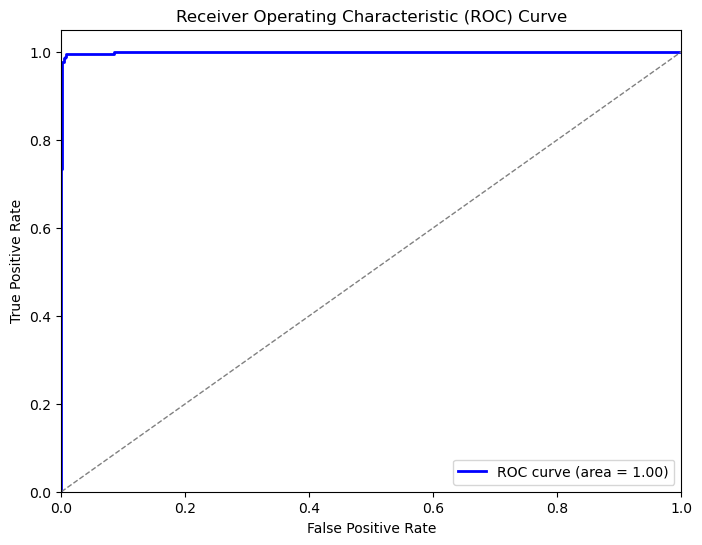

In [28]:
# Get predicted probabilities for the positive class
y_probabilities = nb_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

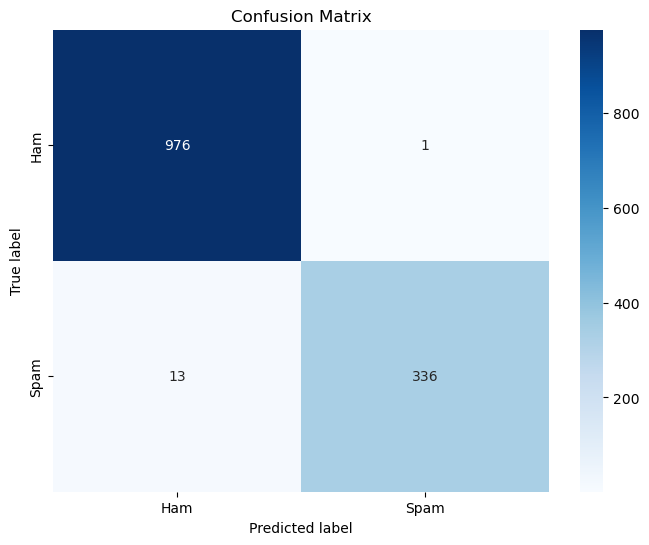

In [29]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## For Data_Processed_PCA

In [16]:
# Define hyperparameter grid for grid search
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Perform grid search using training and validation sets
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_val_pca, y_val_pca)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 772, in fit
    self._count(X, Y)
  File "C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 894, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1490, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


In [ ]:
# Initialize Naive Bayes classifier with best hyperparameters
nb_best = MultinomialNB(**grid_search.best_params_)

# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(nb_best, X_val_pca, y_val_pca, cv=10, scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean CV Accuracy (after hyperparameter tuning):", cv_scores.mean())

In [ ]:
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(nb_best, X_val_pca, y_val_pca, cv=StratifiedKFold(n_splits=10), scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean Stratified CV Accuracy (after hyperparameter tuning):", scv_scores.mean())

In [ ]:
# Finally, train the model on the entire training set and evaluate it on the test set
nb_best.fit(X_train_pca, y_train_pca)
y_test_pred_pca = nb_best.predict(X_test_pca)

# Compute evaluation metrics on the test set
accuracy_pca = accuracy_score(y_test_pca, y_test_pred_pca)
precision_pca = precision_score(y_test_pca, y_test_pred_pca, average='macro')
recall_pca = recall_score(y_test_pca, y_test_pred_pca, average='macro')
f1_pca = f1_score(y_test_pca, y_test_pred_pca, average='macro')
roc_auc_pca = roc_auc_score(y_test_pca, y_test_pred_pca)

print("Test Accuracy:", accuracy_pca)
print("Test Precision:", precision_pca)
print("Test Recall:", recall_pca)
print("Test F1-score:", f1_pca)
print("Test ROC AUC:", roc_auc_pca)

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_pca, y_test_pred_pca)

# # Compute ROC AUC score
# roc_auc = roc_auc_score(y_test,y_test_pred)
# print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_pca)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

# K-Nearest Neighbors

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
# Define hyperparameter grid for grid search
param_grid = {'n_neighbors': [3, 5, 7]}

# Perform grid search using training and validation sets
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_val, y_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'n_neighbors': 5}


In [31]:
# Initialize KNN classifier with best hyperparameters
knn_best = KNeighborsClassifier(**grid_search.best_params_)

# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(knn_best, X_val, y_val, cv=10, scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean CV Accuracy (after hyperparameter tuning):", cv_scores.mean())

Mean CV Accuracy (after hyperparameter tuning): 0.9698393711551606


In [32]:
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(knn_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean CV Accuracy (after hyperparameter tuning):", scv_scores.mean())

Mean CV Accuracy (after hyperparameter tuning): 0.9698393711551606


In [33]:
knn_best.fit(X_train, y_train)
y_test_pred = knn_best.predict(X_test)

# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

Test Accuracy: 0.9879336349924586
Test Precision: 0.9882697947214076
Test Recall: 0.9656160458452722
Test F1-score: 0.9768115942028985
Test ROC AUC: 0.9807609400157784


Test ROC AUC: 0.9959600906816669


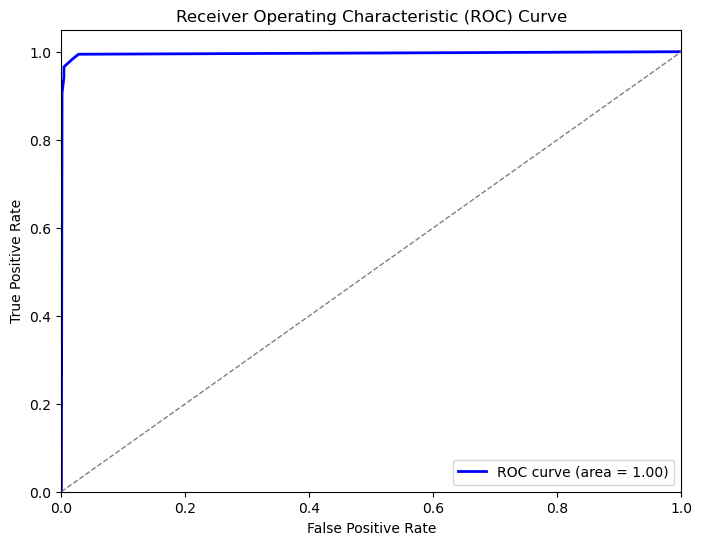

In [34]:
# Get predicted probabilities for the positive class
y_probabilities = knn_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

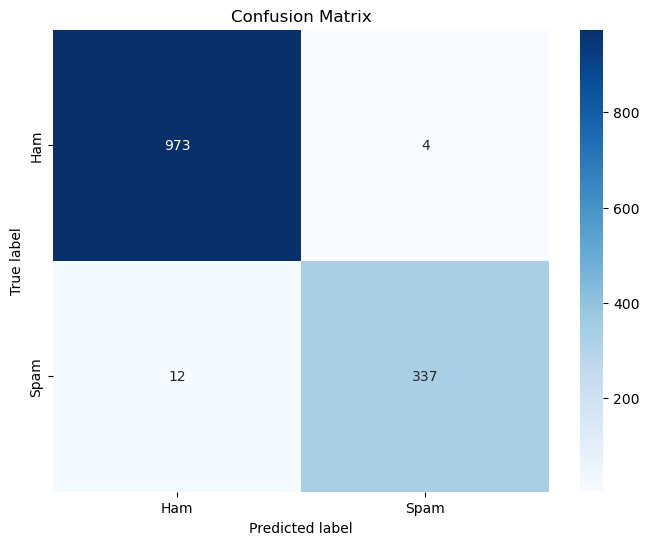

In [35]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

# Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
# Define hyperparameter grid for grid search
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs'],
    #'max_iter': [100, 200, 300],
}

# Perform grid search using training and validation sets
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_val, y_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}


C:\Users\ashwi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [38]:
# Initialize logistic regression classifier with best hyperparameters
lr_best = LogisticRegression(**grid_search.best_params_, max_iter=1000)

# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(lr_best, X_val, y_val, cv=10, scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean CV Accuracy (after hyperparameter tuning):", cv_scores.mean())

Mean CV Accuracy (after hyperparameter tuning): 0.9871610845295056


In [39]:
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(lr_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean CV Accuracy (after hyperparameter tuning):", scv_scores.mean())

Mean CV Accuracy (after hyperparameter tuning): 0.9886762360446569


In [40]:
# Finally, train the model on the entire training set and evaluate it on the test set
lr_best.fit(X_train, y_train)
y_test_pred = lr_best.predict(X_test)

# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

Test Accuracy: 0.9947209653092006
Test Precision: 1.0
Test Recall: 0.9799426934097422
Test F1-score: 0.9898697539797395
Test ROC AUC: 0.9899713467048711


Test ROC AUC: 0.9998914870092354


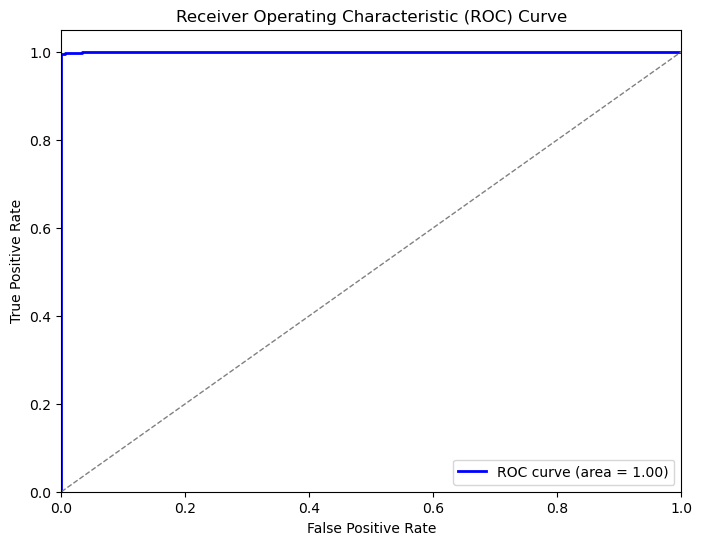

In [41]:
# Get predicted probabilities for the positive class
y_probabilities = lr_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

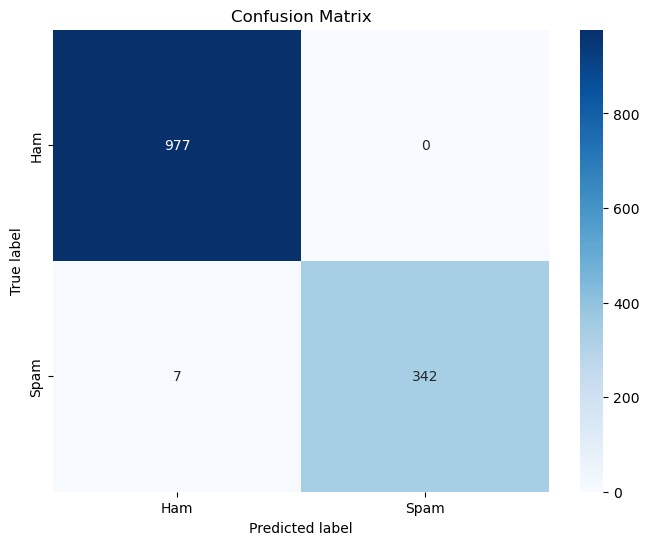

In [42]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()

## AdaBoost Classifier

In [37]:
from sklearn.ensemble import AdaBoostClassifier

In [39]:
# Define hyperparameter grid for grid search
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0]}

# Perform grid search using training and validation sets
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_val, y_val)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
# Initialize AdaBoost classifier with best hyperparameters
adaboost_best = AdaBoostClassifier(**grid_search.best_params_)

# Perform cross-validation with best hyperparameters
cv_scores = cross_val_score(adaboost_best, X_val, y_val, cv=10, scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean CV Accuracy (after hyperparameter tuning):", cv_scores.mean())

In [ ]:
# Perform cross-validation with best hyperparameters
scv_scores = cross_val_score(adaboost_best, X_val, y_val, cv=StratifiedKFold(n_splits=10), scoring='accuracy')

# Print mean cross-validation accuracy
print("Mean CV Accuracy (after hyperparameter tuning):", scv_scores.mean())

In [ ]:
# Finally, train the model on the entire training set and evaluate it on the test set
adaboost_best.fit(X_train, y_train)
y_test_pred = adaboost_best.predict(X_test)

# Compute evaluation metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC AUC:", roc_auc)

In [ ]:
# Get predicted probabilities for the positive class
y_probabilities = adaboost_best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print("Test ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.yticks([0.5, 1.5], ['Ham', 'Spam'])  # Specify the labels for binary classification
plt.show()